<a href="https://colab.research.google.com/github/emmenets/neuralnetwork/blob/master/190731_rastionlydetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
!git clone https://github.com/tensorflow/models.git

In [0]:
cd /content/models/research/object_detection

In [0]:
cp -r /gdrive/My\ Drive/colabfiles/lektion31/inference_graph /content/models/research/object_detection

In [0]:
mkdir training

In [0]:
cd /content/models/research/

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

In [0]:
!python setup.py build

In [0]:
!python setup.py install

In [0]:
cd /content/models/research/object_detection

In [0]:
%%writefile training/label_map.pbtxt

item {
  id: 1
  name: 'rasti'
}

In [0]:
%%writefile training/faster_rcnn_inception_v2_pets.config

# Faster R-CNN with Inception v2, configured for Oxford-IIIT Pets Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_inception_v2'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0002
          schedule {
            step: 900000
            learning_rate: .00002
          }
          schedule {
            step: 1200000
            learning_rate: .000002
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "/content/models/research/object_detection/faster_rcnn_inception_v2_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  load_all_detection_checkpoint_vars: true
  # Note: The below line limits the training process to 200K steps, which we
  # empirically found to be sufficient enough to train the pets dataset. This
  # effectively bypasses the learning rate schedule (the learning rate will
  # never decay). Remove the below line to train indefinitely.
  num_steps: 200000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}


train_input_reader: {
  tf_record_input_reader {
    input_path: "/content/models/research/object_detection/train.record"
  }
  label_map_path: "/content/models/research/object_detection/training/label_map.pbtxt"
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  num_examples: 70
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "/content/models/research/object_detection/test.record"
  }
  label_map_path: "/content/models/research/object_detection/training/label_map.pbtxtt"
  shuffle: false
  num_readers: 1
}

In [0]:
!cp -R /content/models/research/slim/nets /content/models/research/object_detection
!cp -R /content/models/research/slim/deployment /content/models/research/object_detection

In [0]:
cp /gdrive/My\ Drive/colabfiles/lektion31/rasenbilder/bildtest159.jpg /content/models/research/object_detection

In [0]:
cp /gdrive/My\ Drive/colabfiles/lektion31/rasen.mov /content/models/research/object_detection

In [0]:
######## Image Object Detection Using Tensorflow-trained Classifier #########
#
# Author: Evan Juras
# Date: 1/15/18
# Description: 
# This program uses a TensorFlow-trained classifier to perform object detection.
# It loads the classifier uses it to perform object detection on an image.
# It draws boxes and scores around the objects of interest in the image.

## Some of the code is copied from Google's example at
## https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

## and some is copied from Dat Tran's example at
## https://github.com/datitran/object_detector_app/blob/master/object_detection_app.py

## but I changed it to make it more understandable to me.

# Import packages
from google.colab.patches import cv2_imshow
import os
import cv2
import numpy as np
import tensorflow as tf
import sys

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
IMAGE_NAME = 'bildtest159.jpg'
#IMAGE_NAME = 'ch (8).jpg'

# Grab path to current working directory
CWD_PATH = os.getcwd()

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','label_map.pbtxt')

# Path to image
PATH_TO_IMAGE = os.path.join(CWD_PATH,IMAGE_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Load image using OpenCV and
# expand image dimensions to have shape: [1, None, None, 3]
# i.e. a single-column array, where each item in the column has the pixel RGB value
image = cv2.imread(PATH_TO_IMAGE)
image_expanded = np.expand_dims(image, axis=0)

# Perform the actual detection by running the model with the image as input
(boxes, scores, classes, num) = sess.run(
    [detection_boxes, detection_scores, detection_classes, num_detections],
    feed_dict={image_tensor: image_expanded})

# Draw the results of the detection (aka 'visulaize the results')

vis_util.visualize_boxes_and_labels_on_image_array(
    image,
    np.squeeze(boxes),
    np.squeeze(classes).astype(np.int32),
    np.squeeze(scores),
    category_index,
    use_normalized_coordinates=True,
    line_thickness=2,
    min_score_thresh=0.80)

# All the results have been drawn on image. Now display the image.
cv2_imshow(image)

# Press any key to close the image
#cv2.waitKey(0)

# Clean up
#cv2.destroyAllWindows()

In [0]:
!mkdir images
!mkdir images/bildverarbeitet/

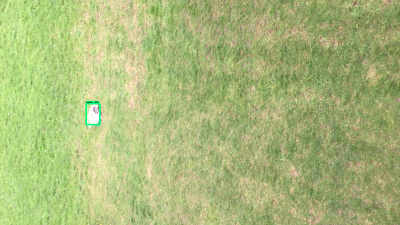

1263


KeyboardInterrupt: ignored

In [34]:
######## Video Object Detection Using Tensorflow-trained Classifier #########
#
# Author: Evan Juras
# Date: 1/16/18
# Description: 
# This program uses a TensorFlow-trained classifier to perform object detection.
# It loads the classifier uses it to perform object detection on a video.
# It draws boxes and scores around the objects of interest in each frame
# of the video.

## Some of the code is copied from Google's example at
## https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

## and some is copied from Dat Tran's example at
## https://github.com/datitran/object_detector_app/blob/master/object_detection_app.py

## but I changed it to make it more understandable to me.

# Import packages
import os
import time
import cv2
import numpy as np
import tensorflow as tf
import sys
import imutils
from IPython.display import clear_output

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

# Import utilites
from utils import label_map_util
from utils import visualization_utils as vis_util

# Name of the directory containing the object detection module we're using
MODEL_NAME = 'inference_graph'
VIDEO_NAME = 'rasen.mov'

# Grab path to current working directory
CWD_PATH = os.getcwd()

print(CWD_PATH)

# Path to frozen detection graph .pb file, which contains the model that is used
# for object detection.
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,'frozen_inference_graph.pb')

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,'training','label_map.pbtxt')

# Path to video
PATH_TO_VIDEO = os.path.join(CWD_PATH,VIDEO_NAME)

# Number of classes the object detector can identify
NUM_CLASSES = 1

# Load the label map.
# Label maps map indices to category names, so that when our convolution
# network predicts `5`, we know that this corresponds to `king`.
# Here we use internal utility functions, but anything that returns a
# dictionary mapping integers to appropriate string labels would be fine
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Load the Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

    sess = tf.Session(graph=detection_graph)

# Define input and output tensors (i.e. data) for the object detection classifier

# Input tensor is the image
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Output tensors are the detection boxes, scores, and classes
# Each box represents a part of the image where a particular object was detected
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represents level of confidence for each of the objects.
# The score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

# Number of objects detected
num_detections = detection_graph.get_tensor_by_name('num_detections:0')

# Open video file
video = cv2.VideoCapture(PATH_TO_VIDEO)
print("ok")
i = 0
bildverarbeitnr = 0
lasttime = time.time()
acttime = time.time()
while(video.isOpened()):

    # Acquire frame and expand frame dimensions to have shape: [1, None, None, 3]
    # i.e. a single-column array, where each item in the column has the pixel RGB value
    ret, frame = video.read()
    if ret==True:
        
        frame_expanded = np.expand_dims(frame, axis=0)

        # Perform the actual detection by running the model with the image as input
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: frame_expanded})

        # Draw the results of the detection (aka 'visulaize the results')
        vis_util.visualize_boxes_and_labels_on_image_array(
            frame,
            np.squeeze(boxes),
            np.squeeze(classes).astype(np.int32),
            np.squeeze(scores),
            category_index,
            use_normalized_coordinates=True,
            line_thickness=8,
            min_score_thresh=0.90)

        # All the results have been drawn on the frame, so it's time to display it.
        
        
        #cv2_imshow(frame)
        #print(boxes)
        cv2.imwrite("/content/models/research/object_detection/images/bildverarbeitet/"+str(bildverarbeitnr)+".jpg", frame)
        bildverarbeitnr += 1
        acttime = time.time()
        
        if acttime - lasttime > 1:
          clear_output()
          frame = imutils.resize(frame, 400)
          cv2_imshow(frame)
          
          print(bildverarbeitnr)
          lasttime = acttime
          
        
        #clear_output()
        

        # Press 'q' to quit
        #print(i)
        #i = i + 1
        #if cv2.waitKey(1) == ord('q'):
        #    break
    else:
        break

# Clean up
print("end1")
#video.release()
#cv2.destroyAllWindows()
print("end2")

# New Section

# New Section